# DEPENDENCIES

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA

In [2]:
def plot_acf(df, col):
    fig, axes = plt.subplots(2, 2, figsize=(24, 6))
    ax1, ax2, ax3, ax4 = axes.flatten()

    sm.graphics.tsa.plot_acf(df[col].values.squeeze(), lags=20, ax=ax1)
    ax1.set_title(f"{col}: ACF of Original Data")

    sm.graphics.tsa.plot_acf(df[col].diff().dropna().values.squeeze(), lags=20, ax=ax2)
    ax2.set_title(f"{col}: ACF of Differenced Data")

    sm.graphics.tsa.plot_pacf(df[col].values.squeeze(), lags=20, ax=ax3)
    ax3.set_title(f"{col}: PACF of Original Data")
    sm.graphics.tsa.plot_pacf(df[col].diff().dropna().values.squeeze(), lags=20, ax=ax4)
    ax4.set_title(f"{col}: PACF of Differenced Data")

    plt.tight_layout()

    plt.show()

# READ DATA

In [3]:
data = pd.read_csv(
    "C:/Users/edmun/OneDrive/Desktop/2025-IMC-Global-Trading-Challenge/Backtest/resources/round0/prices_round_0_day_-2.csv",
    sep=";",
)

In [4]:
#################################### VOLUME METRICS ####################################

# Most Bid Volume - Identifies which bid price has the highest volume.
data["most_bid_volume_idx"] = data[
    ["bid_volume_1", "bid_volume_2", "bid_volume_3"]
].idxmax(axis=1)

# Most Ask Volume - Identifies which ask price has the highest volume.
data["most_ask_volume_idx"] = data[
    ["ask_volume_1", "ask_volume_2", "ask_volume_3"]
].idxmax(axis=1)

# Highest Bid Volume - The highest bid volume across the three bid price levels.
data["most_bid_volume"] = data[["bid_volume_1", "bid_volume_2", "bid_volume_3"]].max(
    axis=1
)

# Highest Ask Volume - The highest ask volume across the three ask price levels.
data["most_ask_volume"] = data[["ask_volume_1", "ask_volume_2", "ask_volume_3"]].max(
    axis=1
)

data["total_bid_volume"] = data[["bid_volume_1", "bid_volume_2", "bid_volume_3"]].sum(
    axis=1
)

data["total_ask_volume"] = data[["ask_volume_1", "ask_volume_2", "ask_volume_3"]].sum(
    axis=1
)

data["volume_ratio"] = data["total_bid_volume"] / data["total_ask_volume"]

data["orderbook_imb"] = (
    (data["total_bid_volume"] - data["total_ask_volume"])
    / (data["total_bid_volume"] + data["total_ask_volume"])
    * 100
)

data["price_impact_sell"] = data["total_bid_volume"] / (
    data["ask_price_1"] - data["bid_price_1"]
)

data["price_impact_buy"] = data["total_ask_volume"] / (
    data["ask_price_1"] - data["bid_price_1"]
)

data["rate_of_bid"] = data.groupby("product")["total_bid_volume"].diff()

data["rate_of_ask"] = data.groupby("product")["total_ask_volume"].diff()


#################################### PRICE METRICS ####################################
# Most Bid Price - Determines the bid price corresponding to the highest bid volume.
data["most_bid"] = np.where(
    data["most_bid_volume_idx"] == "bid_volume_1",
    data["bid_price_1"],
    np.where(
        data["most_bid_volume_idx"] == "bid_volume_2",
        data["bid_price_2"],
        np.where(
            data["most_bid_volume_idx"] == "bid_volume_3", data["bid_price_3"], np.nan
        ),
    ),
)

# Most Ask Price - Determines the ask price corresponding to the highest ask volume.
data["most_ask"] = np.where(
    data["most_ask_volume_idx"] == "ask_volume_1",
    data["ask_price_1"],
    np.where(
        data["most_ask_volume_idx"] == "ask_volume_2",
        data["ask_price_2"],
        np.where(
            data["most_ask_volume_idx"] == "ask_volume_3", data["ask_price_3"], np.nan
        ),
    ),
)

#################################### MID PRICE METRICS ####################################
# Most Mid Price - The mid price of the highest bid and ask prices.
data["most_mid"] = (data["most_ask"] + data["most_bid"]) / 2


#################################### VWAP METRICS ####################################
# Most Micro Price - A weighted average price using both bid and ask volumes.
data["most_micro"] = (
    data["most_ask"] * data["most_bid_volume"]
    + data["most_bid"] * data["most_ask_volume"]
) / (data["most_ask_volume"] + data["most_bid_volume"])

# Micro Price - A weighted average price based on the first bid and ask levels.
data["micro_price"] = (
    data["ask_price_1"] * data["bid_volume_1"]
    + data["bid_price_1"] * data["ask_volume_1"]
) / (data["ask_volume_1"] + data["bid_volume_1"])

# Ask VWAP - The volume-weighted average price for the ask side using the top 3 ask levels.
data["ask_vwap"] = (
    data["ask_price_1"] * data["ask_volume_1"]
    + data["ask_price_2"] * data["ask_volume_2"]
    + data["ask_price_3"] * data["ask_volume_3"]
) / (data["ask_volume_1"] + data["ask_volume_2"] + data["ask_volume_3"])

# Bid VWAP - The volume-weighted average price for the bid side using the top 3 bid levels.
data["bid_vwap"] = (
    data["bid_price_1"] * data["bid_volume_1"]
    + data["bid_price_2"] * data["bid_volume_2"]
    + data["bid_price_3"] * data["bid_volume_3"]
) / (data["bid_volume_1"] + data["bid_volume_2"] + data["bid_volume_3"])

# VWAP Mid - The VWAP midpoint between the ask and bid sides.
data["vwap_mid"] = (data["ask_vwap"] + data["bid_vwap"]) / 2


In [5]:
data.columns

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss',
       'most_bid_volume_idx', 'most_ask_volume_idx', 'most_bid_volume',
       'most_ask_volume', 'total_bid_volume', 'total_ask_volume',
       'volume_ratio', 'orderbook_imb', 'price_impact_sell',
       'price_impact_buy', 'rate_of_bid', 'rate_of_ask', 'most_bid',
       'most_ask', 'most_mid', 'most_micro', 'micro_price', 'ask_vwap',
       'bid_vwap', 'vwap_mid'],
      dtype='object')

In [6]:
prices = [
    "mid_price",
    "most_mid",
    "most_micro",
    "micro_price",
    "vwap_mid",
]

# Resin

In [7]:
resin = data[data["product"] == "RAINFOREST_RESIN"].fillna(0)

In [8]:
resin["bid_price_1"].value_counts().sort_index()

bid_price_1
9995     536
9996     955
9998     299
10000     34
10002    176
Name: count, dtype: int64

In [9]:
resin["ask_price_1"].value_counts().sort_index()

ask_price_1
9998      153
10000      37
10002     259
10004    1006
10005     545
Name: count, dtype: int64

max sell @ bid = 9999 because min ask is 9998, sell at bid buy at ask

max buy @ ask = 10_001 because max bid = 10_002, buy at ask sell at bid

In [16]:
resin[resin['ask_price_1'] <= 10_001]['timestamp'].diff().dropna().value_counts()

timestamp
200.0     24
100.0     17
1000.0    12
400.0     11
800.0     10
300.0     10
1100.0    10
700.0      9
500.0      8
600.0      8
900.0      8
1600.0     6
1300.0     6
1200.0     6
1400.0     5
1500.0     5
2200.0     5
1900.0     4
1800.0     4
2100.0     3
2300.0     3
2400.0     2
3200.0     2
1700.0     1
4800.0     1
3100.0     1
2900.0     1
4000.0     1
4500.0     1
4600.0     1
3500.0     1
4100.0     1
5000.0     1
2600.0     1
Name: count, dtype: int64

In [17]:
resin[resin['bid_price_1'] >= 9999]['timestamp'].diff().dropna().value_counts()

timestamp
100.0     23
700.0     22
300.0     20
800.0     18
400.0     15
200.0     11
500.0     10
1100.0    10
600.0      8
900.0      8
1000.0     8
1200.0     7
1300.0     6
2000.0     5
1500.0     5
1900.0     4
1700.0     3
1400.0     3
3000.0     3
1600.0     2
2700.0     2
2600.0     2
2300.0     2
2100.0     2
2400.0     1
5900.0     1
3900.0     1
3200.0     1
2200.0     1
3500.0     1
3100.0     1
5400.0     1
3600.0     1
1800.0     1
Name: count, dtype: int64

## KELP

In [10]:
kelp = data[data["product"] == "KELP"].fillna(0)

In [11]:
kelp

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,rate_of_bid,rate_of_ask,most_bid,most_ask,most_mid,most_micro,micro_price,ask_vwap,bid_vwap,vwap_mid
1,-1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,...,0.0,0.0,2025.0,2029.0,2027.0,2026.933333,2028.031250,0.000000,2025.15625,0.0
2,-1,100,KELP,2025,24,0.0,0.0,0.0,0.0,2028,...,-8.0,-7.0,2025.0,2029.0,2027.0,2027.086957,2027.769231,0.000000,0.00000,0.0
5,-1,200,KELP,2025,22,0.0,0.0,0.0,0.0,2028,...,-2.0,-4.0,2025.0,2028.0,2026.5,2026.571429,2026.571429,0.000000,0.00000,0.0
6,-1,300,KELP,2025,31,0.0,0.0,0.0,0.0,2028,...,9.0,11.0,2025.0,2029.0,2027.0,2027.066667,2027.818182,0.000000,0.00000,0.0
9,-1,400,KELP,2025,27,0.0,0.0,0.0,0.0,2028,...,-4.0,-4.0,2025.0,2028.0,2026.5,2026.500000,2026.500000,0.000000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990,-1,199500,KELP,2020,23,0.0,0.0,0.0,0.0,2024,...,0.0,-4.0,2020.0,2024.0,2022.0,2022.000000,2022.000000,0.000000,0.00000,0.0
3992,-1,199600,KELP,2020,22,0.0,0.0,0.0,0.0,2023,...,-1.0,-1.0,2020.0,2024.0,2022.0,2022.046512,2022.869565,0.000000,0.00000,0.0
3995,-1,199700,KELP,2020,27,0.0,0.0,0.0,0.0,2023,...,5.0,5.0,2020.0,2024.0,2022.0,2022.076923,2022.793103,0.000000,0.00000,0.0
3997,-1,199800,KELP,2020,21,0.0,0.0,0.0,0.0,2023,...,-6.0,-6.0,2020.0,2023.0,2021.5,2021.500000,2021.500000,0.000000,0.00000,0.0


### ACF / PACF PLOT
Slow decay in ACF => time series not stationary => Differencing required

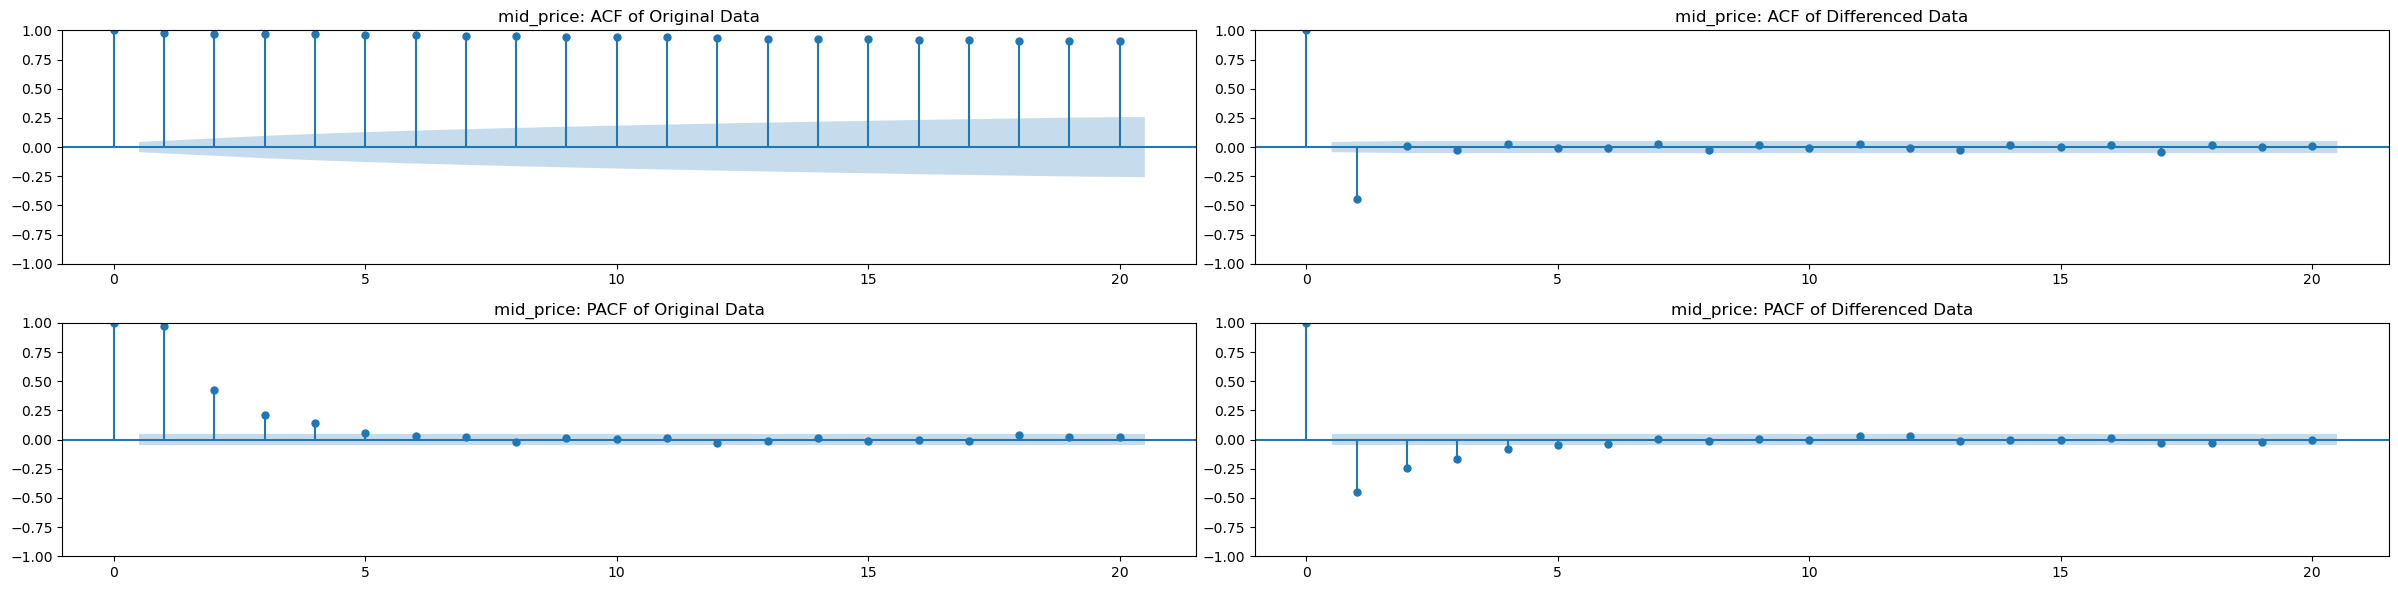

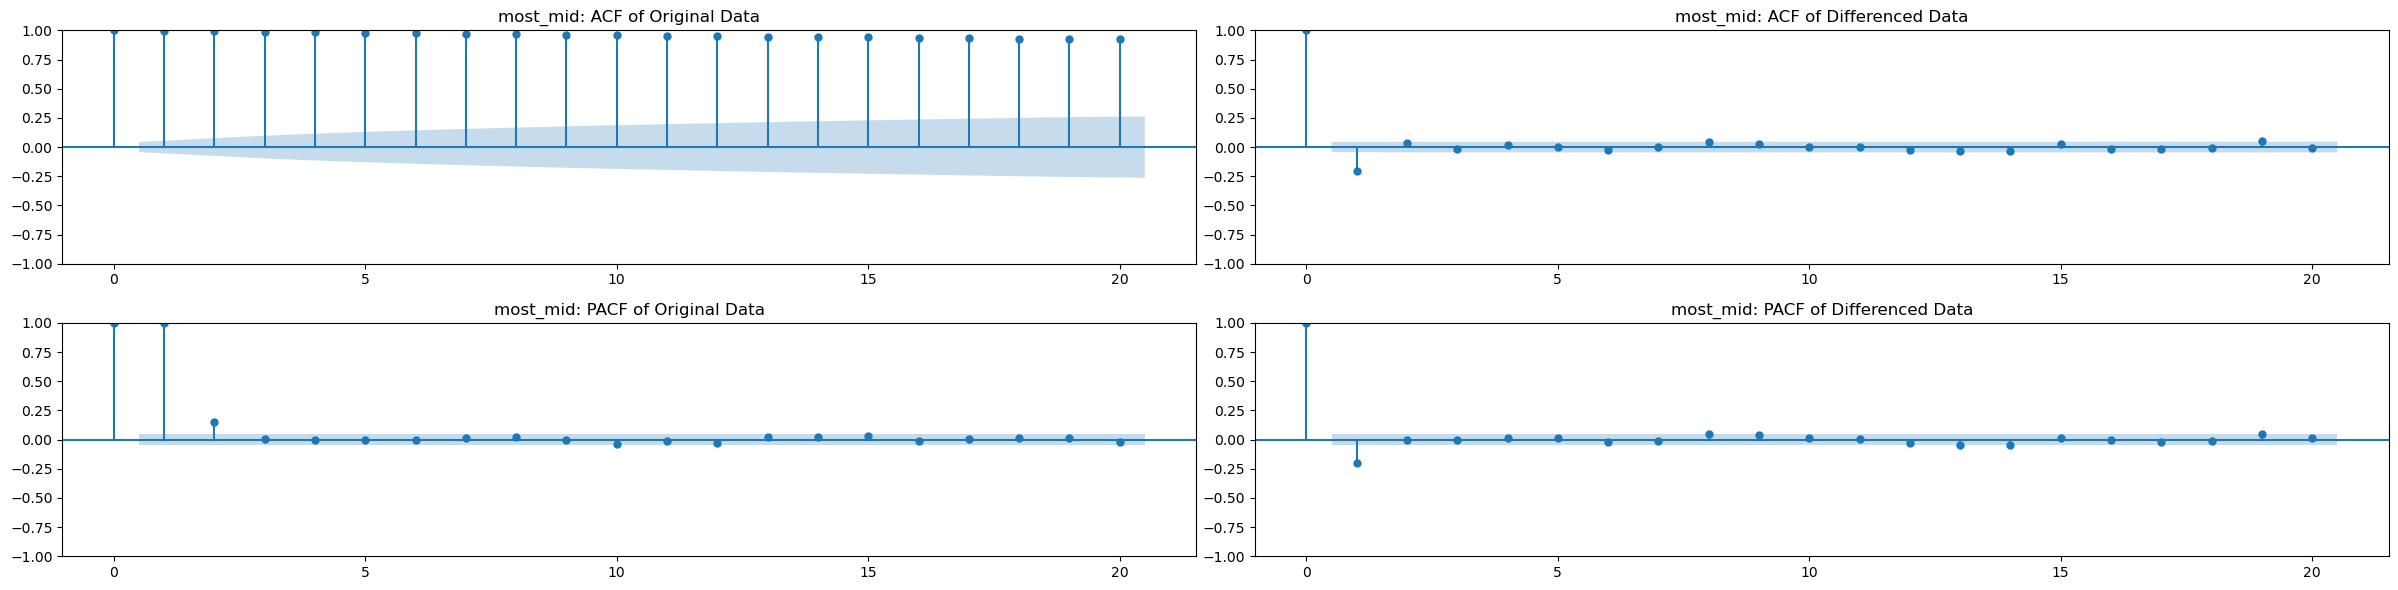

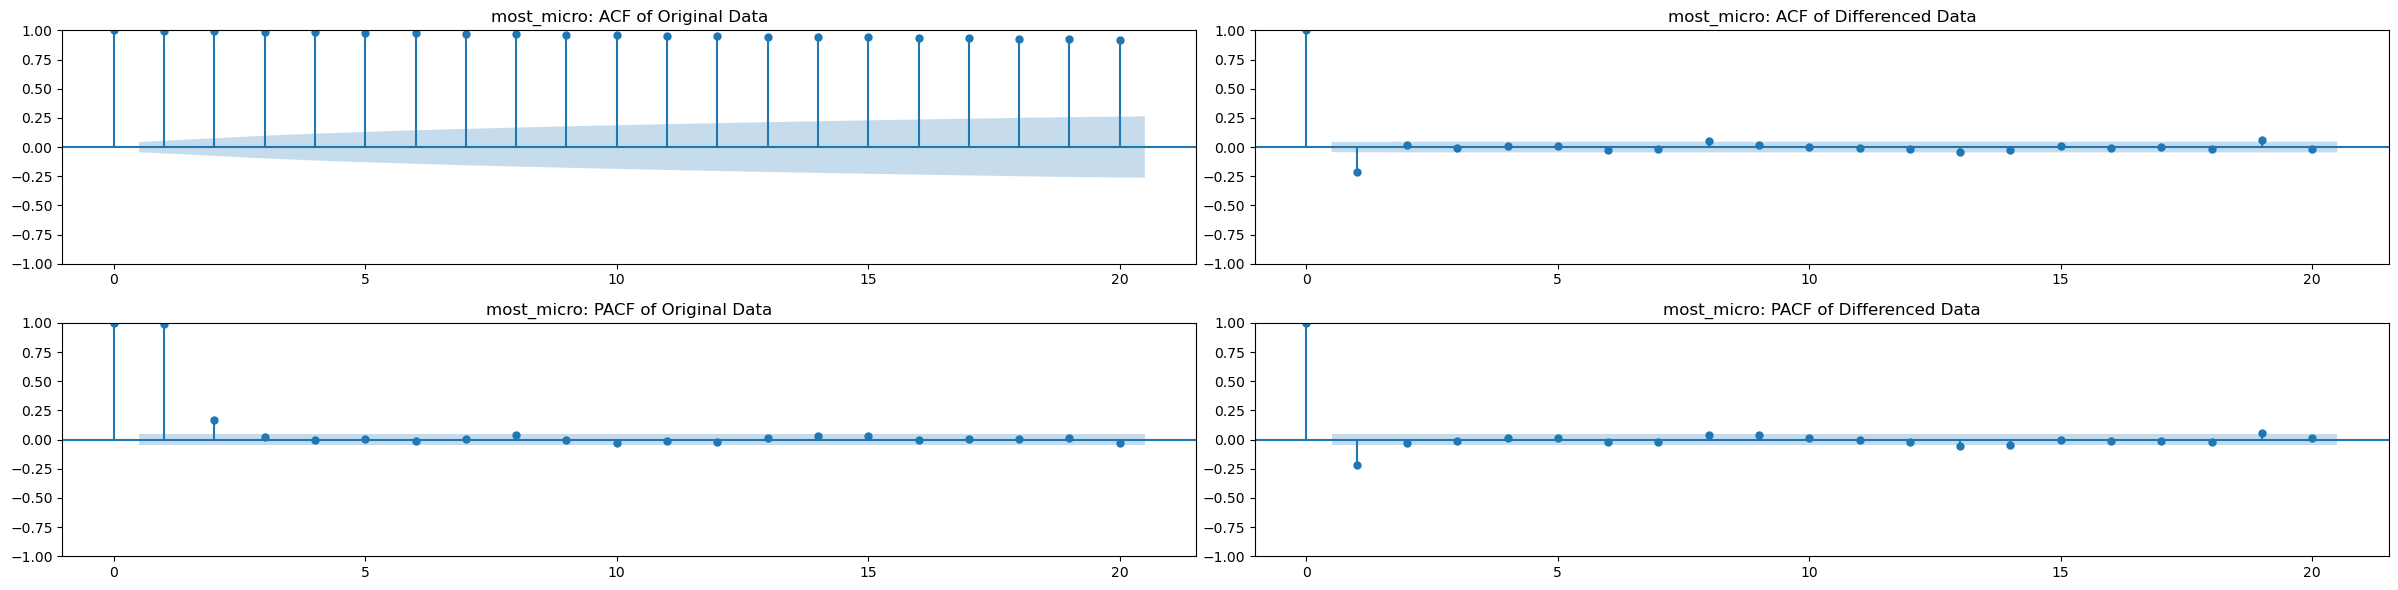

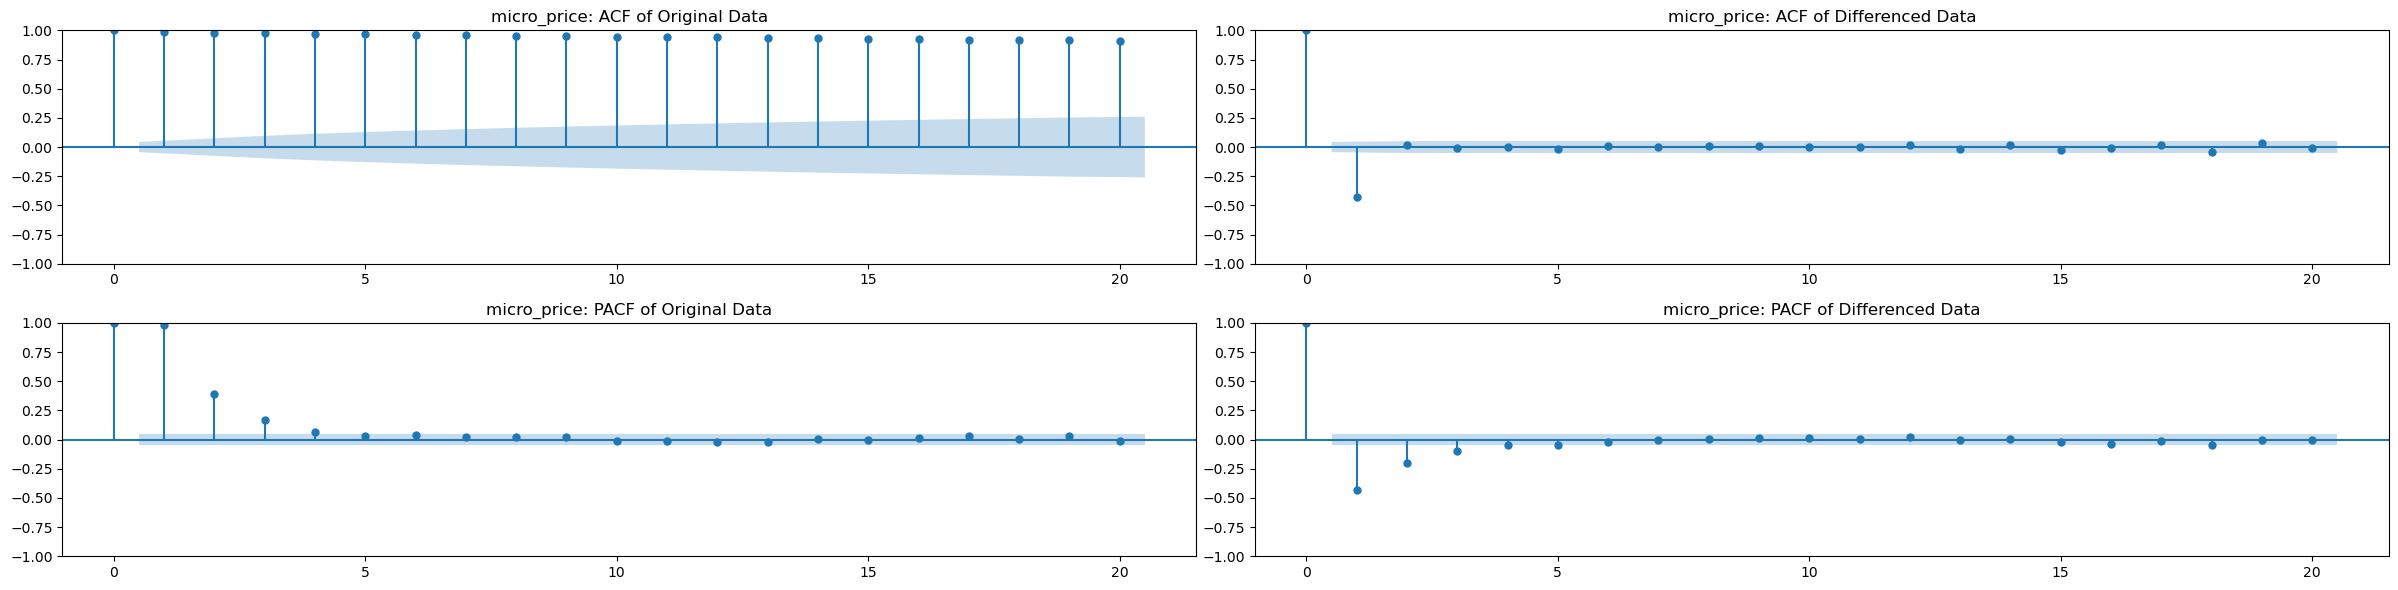

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1491: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1491: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


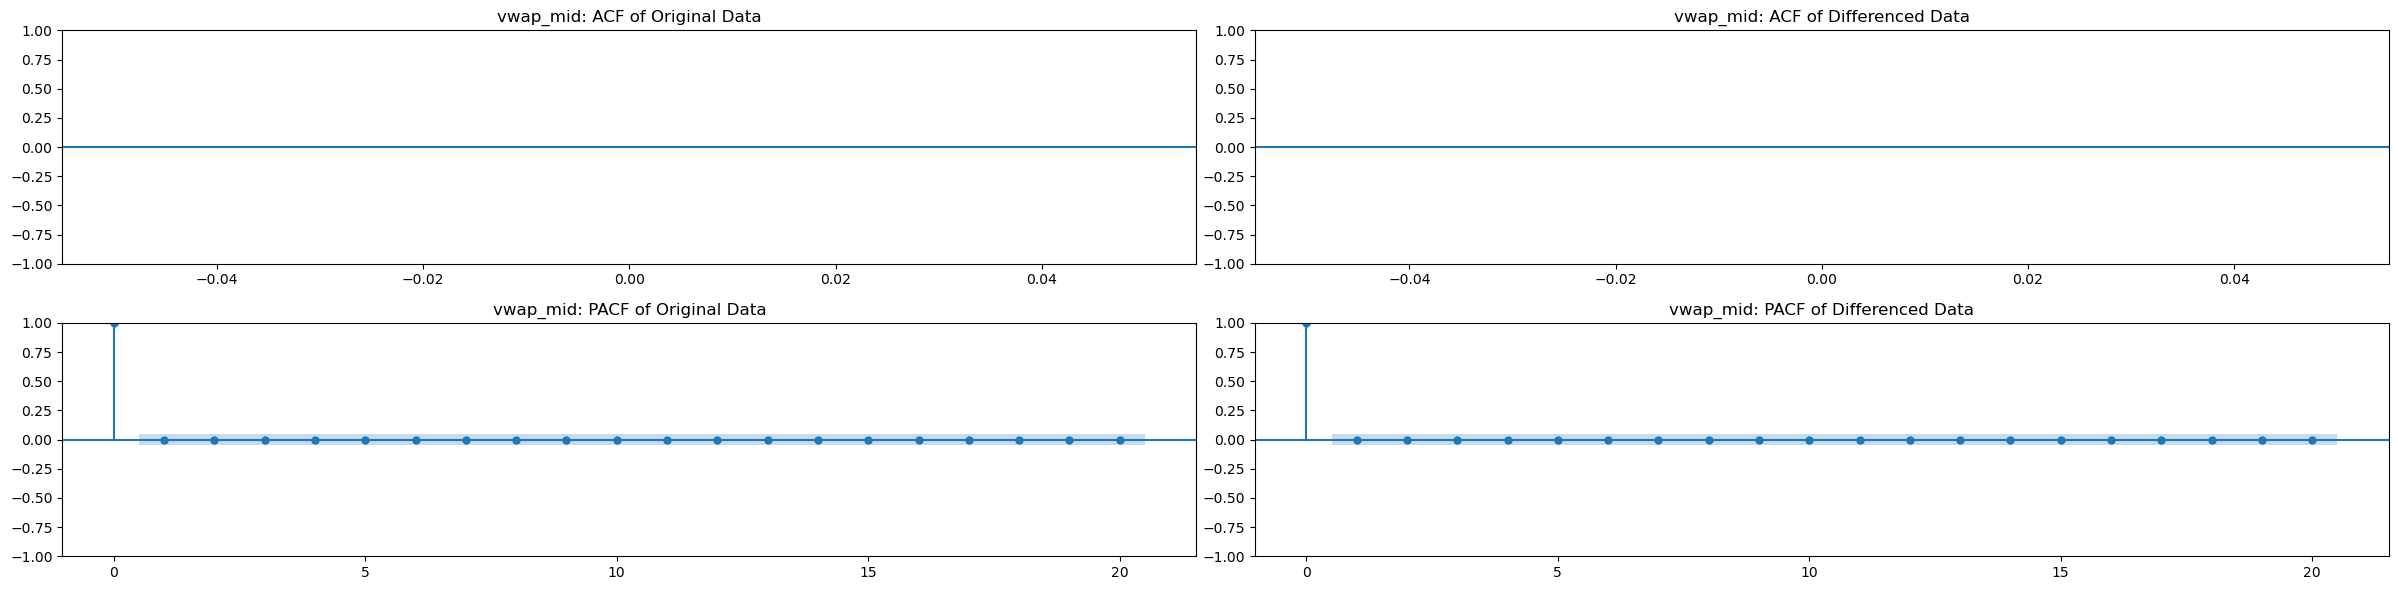

In [12]:
for price in prices:
    plot_acf(df=kelp, col=price)

After differencing, observe a 1 lag before sharp drop => differenced time series follows MA(1) \
This is confirmed by the exponentional decay in PACF of differenced time series

## MA(1) MODEL

## Single Factor
Running MA(1) model on 1 Endogeneous variable

In [13]:
for price in prices:
    print(f"########################   {price}   ##########################")
    arima = ARIMA(endog=kelp[price].values, order=(0, 1, 1)).fit()
    print(arima.summary())

########################   mid_price   ##########################
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2015.122
Date:                Sun, 06 Apr 2025   AIC                           4034.244
Time:                        16:52:31   BIC                           4045.445
Sample:                             0   HQIC                          4038.357
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6131      0.016    -37.491      0.000      -0.645      -0.581
sigma2         0.4396      0.012     36.205      0.000       0.41

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1420: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


## Single factor with exogeneous variable
Running MA(1) model on 1 Endogeneous variable + 1 Exogeneous variable

In [14]:
for price in prices[1:]:
    print(
        f"########################   MID_PRICE + {price}   ##########################"
    )
    arima = ARIMA(
        endog=kelp["mid_price"].values,
        exog=kelp[price].diff().fillna(0).values,
        order=(0, 1, 1),
    ).fit()
    print(arima.summary())

########################   MID_PRICE + most_mid   ##########################
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1945.116
Date:                Sun, 06 Apr 2025   AIC                           3896.233
Time:                        16:52:32   BIC                           3913.034
Sample:                             0   HQIC                          3902.402
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4554      0.036     12.633      0.000       0.385       0.526
ma.L1         -0.5962      0.017    -35.886      0.000

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3014: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse


## Single factor with multiple exogeneous variables
Running MA(1) model on 1 Endogeneous variable + multiple exogeneous variable

In [15]:
from itertools import combinations

for i in range(2, 5):
    for combi in combinations(prices[1:], i):
        print(
            f"########################   MID_PRICE + {combi}   ##########################"
        )
        arima = ARIMA(
            endog=kelp["mid_price"].values,
            exog=kelp[list(combi)].diff().fillna(0).values,
            order=(0, 1, 1),
        ).fit()
        print(arima.summary())

########################   MID_PRICE + ('most_mid', 'most_micro')   ##########################
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1944.144
Date:                Sun, 06 Apr 2025   AIC                           3896.288
Time:                        16:52:32   BIC                           3918.690
Sample:                             0   HQIC                          3904.514
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6626      0.161      4.105      0.000       0.346       0.979
x2            -0.2055      0.158    

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3014: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1953.429
Date:                Sun, 06 Apr 2025   AIC                           3914.857
Time:                        16:52:33   BIC                           3937.259
Sample:                             0   HQIC                          3923.083
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4120      0.035     11.644      0.000       0.343       0.481
const               0         -0        nan        nan           0           0
ma.L1         -0.5989      0.016    -36.322      0.0

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3014: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse


## Potential Models

### MID PRICE + MICRO PRICE DIFF

In [16]:
arima = ARIMA(
    endog=kelp["mid_price"].values,
    exog=kelp["micro_price"].diff().fillna(0).values,
    order=(0, 1, 1),
).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1872.768
Date:                Sun, 06 Apr 2025   AIC                           3751.536
Time:                        16:52:35   BIC                           3768.337
Sample:                             0   HQIC                          3757.705
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3068      0.015     20.547      0.000       0.278       0.336
ma.L1         -0.5687      0.017    -32.584      0.000      -0.603      -0.535
sigma2         0.3812      0.011     33.805      0.0

In [17]:
arima.params

array([ 0.30679742, -0.56871383,  0.3812184 ])

### MID PRICE + NOST MID DIFF MICRO PRICE DIFF

In [18]:
arima = ARIMA(
    endog=kelp["mid_price"].values,
    exog=kelp[list(("most_mid", "micro_price"))].diff().fillna(0).values,
    order=(0, 1, 1),
).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1869.078
Date:                Sun, 06 Apr 2025   AIC                           3746.156
Time:                        16:52:35   BIC                           3768.558
Sample:                             0   HQIC                          3754.382
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1211      0.040      3.019      0.003       0.042       0.200
x2             0.2722      0.018     15.373      0.000       0.237       0.307
ma.L1         -0.5687      0.018    -32.384      0.0

In [19]:
arima.params

array([ 0.12107209,  0.27218619, -0.56866306,  0.3798141 ])

### MID PRICE + NOST MID DIFF + MOST MICRO DIFF + MICRO PRICE DIFF

In [20]:
arima = ARIMA(
    endog=kelp["mid_price"].values,
    exog=kelp[list(("most_mid", "most_micro", "micro_price"))].diff().fillna(0).values,
    order=(0, 1, 1),
).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1859.470
Date:                Sun, 06 Apr 2025   AIC                           3728.941
Time:                        16:52:35   BIC                           3756.943
Sample:                             0   HQIC                          3739.223
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7270      0.151      4.829      0.000       0.432       1.022
x2            -0.6269      0.152     -4.129      0.000      -0.925      -0.329
x3             0.2934      0.018     16.081      0.0

In [21]:
arima.params

array([ 0.72702633, -0.6269381 ,  0.29338536, -0.56475013,  0.37617876])

# Dynamic Parameter

In [24]:
import numpy as np
from numba import njit, prange


@njit
def log_likelihood(y_diff, residual):
    sigma2 = 0.29756816
    # Number of observations
    T = len(y_diff)

    ll = -T / 2 * np.log(2 * np.pi * sigma2) - (1 / (2 * sigma2)) * np.sum(
        (residual) ** 2
    )

    return -ll


@njit
def gradient(params, y_diff, X1_diff, X2_diff):
    theta_1, beta_1, beta_2 = params
    sigma2 = 0.29756816
    mu = 0
    y_diff_prev, X1_diff, X2_diff = (
        y_diff[:-1],
        X1_diff[1:],
        X2_diff[1:],
    )
    residual = (
        y_diff[1:] - mu - theta_1 * y_diff_prev - beta_1 * X1_diff - beta_2 * X2_diff
    )

    dL_dtheta_1 = np.sum(y_diff_prev * (residual)) / sigma2
    dL_dbeta_1 = np.sum(X1_diff * (residual)) / sigma2
    dL_dbeta_2 = np.sum(X2_diff * (residual)) / sigma2

    return np.array([-dL_dtheta_1, -dL_dbeta_1, -dL_dbeta_2]), residual


@njit
def gradient_descent(
    y_diff,
    X1_diff,
    X2_diff,
    initial_params,
    learning_rate,
    max_iter=100,
    tolerance=1e-5,
):
    params = np.array(initial_params)
    prev_loss = 1e10
    for i in range(max_iter):
        grad, residual = gradient(params, y_diff, X1_diff, X2_diff)
        loss = log_likelihood(y_diff, residual)
        params -= learning_rate * grad

        if prev_loss - loss < tolerance:
            break
        else:
            prev_loss = loss
    return params

In [29]:
interested = 14e-7
for _ in range(1000):
    stability = {"theta_1": [], "theta_2": [], "theta_3": []}
    interested += 1e-6
    learning_rate = np.array(
        [7.073e-5, 1.11534e-4, interested]
    )  # np.array([25e-7, 35e-7, 35e-7])
    for i in prange(2_000 - 20):
        y_diff = np.diff(kelp["mid_price"].values)[i : i + 20]
        X1_diff = np.diff(kelp["most_mid"].values)[i : i + 20]
        X2_diff = np.diff(kelp["micro_price"].values)[i : i + 20]

        # Initial guess
        initial_guess = [-0.603, 0.1, 0.237]  # [-0.56866306, 0.12107209, 0.27218619]

        # Run gradient descent to estimate parameters
        estimated_params = gradient_descent(
            y_diff, X1_diff, X2_diff, initial_guess, learning_rate
        )
        stability["theta_1"].append(estimated_params[0])
        stability["theta_2"].append(estimated_params[1])
        stability["theta_3"].append(estimated_params[2])

    print(np.median(stability["theta_3"]))

    if abs(np.median(stability["theta_3"]) - 0.27218619) < 0.0001:
        print(np.median(stability["theta_3"]))
        print(interested)
        break

    # print(f"Estimated theta_1: {estimated_params[0]}")
    # print(f"Estimated beta_1: {estimated_params[1]}")
    # print(f"Estimated beta_2: {estimated_params[2]}")


0.23809597517373604
0.2385502387958672
0.23900337806397534
0.23945536970372178
0.23990680920561042
0.24035682561507415
0.2408055838139263
0.2412541837105475
0.2417030863662109
0.24214968033334655
0.24259295822634666
0.24303282607782817
0.24347109471568737
0.24390958639365343
0.24434668904098067
0.2447805749618513
0.2452106101703661
0.24564303580019042
0.2460751251239176
0.2465061970985129
0.2469408149793023
0.24737486960653088
0.24780546036054316
0.24823502534433123
0.2486635670841697
0.24909108809997232
0.2495182186901734
0.249944902775239
0.25037064931255093
0.25079334981135637
0.2512161745244058
0.2516392384740218
0.25206138826349267
0.2524826261384716
0.25290295433861737
0.25332375713010763
0.2537456932543301
0.2541578811789059
0.2545643905287261
0.25497146447180313
0.25538795619692317
0.2558036413796493
0.256220654559853
0.2566332357806358
0.2570458736912442
0.25745944256342446
0.2578763120392019
0.25829258874589545
0.2587082737099051
0.25912336795562174
0.25954091375654875
0.2599

In [ ]:
stability = {"theta_1": [], "theta_2": [], "theta_3": []}
learning_rate = np.array(
    [7.073e-5, 1.11534e-4, 1.076e-4]
)  # np.array([2.34e-6, 3.62e-6, 3.46e-6]) # np.array([7.073e-5, 1.11534e-4, 1.076e-4])
for i in prange(2_000 - 20):
    y_diff = np.diff(kelp["mid_price"].values)[i : i + 20]
    X1_diff = np.diff(kelp["most_mid"].values)[i : i + 20]
    X2_diff = np.diff(kelp["micro_price"].values)[i : i + 20]

    # Initial guess
    initial_guess = [-0.603, 0.1, 0.237]  # [-0.56866306, 0.12107209, 0.27218619]

    # Run gradient descent to estimate parameters
    estimated_params = gradient_descent(
        y_diff, X1_diff, X2_diff, initial_guess, learning_rate
    )
    stability["theta_1"].append(estimated_params[0])
    stability["theta_2"].append(estimated_params[1])
    stability["theta_3"].append(estimated_params[2])

print(f"Estimated theta_1: {estimated_params[0]}")
print(f"Estimated beta_1: {estimated_params[1]}")
print(f"Estimated beta_2: {estimated_params[2]}")


Estimated theta_1: -0.5835634396730283
Estimated beta_1: 0.14742131391140526
Estimated beta_2: 0.3344977764119463


In [ ]:
print(np.median(stability["theta_1"]), np.std(stability["theta_1"]))
print(np.median(stability["theta_2"]), np.std(stability["theta_2"]))
print(np.median(stability["theta_3"]), np.std(stability["theta_3"]))

-0.5680659525304306 0.029011293353091074
0.11912797283983721 0.02641447430502138
0.2720953355870433 0.060355582165855015


In [ ]:
print(np.median(stability["theta_1"]), np.std(stability["theta_1"]))
print(np.median(stability["theta_2"]), np.std(stability["theta_2"]))
print(np.median(stability["theta_3"]), np.std(stability["theta_3"]))

-0.5680659525304306 0.029011293353091074
0.11912797283983721 0.02641447430502138
0.2720953355870433 0.060355582165855015


In [ ]:
import plotly.express as px

px.histogram(stability["theta_1"])